# Import Modules

In [16]:
from scipy.io import loadmat
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import jaxopt
import time
import matplotlib.pyplot as plt

# Data Preparation

In [55]:
rw = jnp.arange(0.1,4.1,0.1)
w = jnp.arange(0.3,4.6,0.1)

Ek = loadmat('ek.mat', simplify_cells=True)['ek']
Ecv = loadmat('ecv.mat', simplify_cells=True)['ecv']
Euu = loadmat('euu.mat', simplify_cells=True)['euu']
Eud = loadmat('eud.mat', simplify_cells=True)['eud']

x1_train = []; x2_train = []; x3_train = []; x4_train = []
y1_train = []; y2_train = []; y3_train = []; y4_train = []

for i in range(len(w)):
    x1_train.append(jnp.array([0, w[i]]))
    y1_train.append(jnp.array([Ek[i]]))

for i in range(18):
    for j in range(len(rw)):
        for k in range(len(w)):
            x = jnp.zeros(23).at[i+5].set(1)
            x2_train.append(jnp.array([*x, rw[j]*w[k], w[k]]))
            y2_train.append(jnp.array([Ecv[i,j,k]]))
            
for i in range(len(rw)):
    for j in range(len(w)):
        for k in range(len(w)):
            
            x3_train.append(jnp.array([*jnp.zeros(5), rw[i]*jnp.sqrt(w[j]**2+w[k]**2), min(w[j],w[k]), max(w[j],w[k])]))
            y3_train.append(jnp.array([Euu[i,j,k]]))
            
            x4_train.append(jnp.array([*jnp.zeros(5), rw[i]*jnp.sqrt(w[j]**2+w[k]**2), min(w[j],w[k]), max(w[j],w[k])]))
            y4_train.append(jnp.array([Eud[i,j,k]]))
            
x1_train = jnp.array(x1_train)
y1_train = jnp.array(y1_train)

x2_train = jnp.array(x2_train)
y2_train = jnp.array(y2_train)

x3_train = jnp.array(x3_train)
y3_train = jnp.array(y3_train)

x4_train = jnp.array(x4_train)
y4_train = jnp.array(y4_train)

# Model:

In [34]:
class AE(eqx.Module):
    net: eqx.nn.MLP
    def __init__(self, key, in_dim=20, hidden_dim=20, out_dim=1, depth=2):
        self.net = eqx.nn.MLP(in_dim, out_dim, hidden_dim, depth, key=key, activation=jax.nn.softplus)
    def __call__(self, x):
        return -self.net(x[5:])*jnp.exp(-x[23]**2/(2*x[24]**2))
    
class EE_Same(eqx.Module):
    net: eqx.nn.MLP
    def __init__(self, key, in_dim=3, hidden_dim=20, out_dim=1, depth=2):
        self.net = eqx.nn.MLP(in_dim, out_dim, hidden_dim, depth, key=key, activation=jax.nn.softplus)
    def __call__(self, x):
        return self.net(x[5:])*jnp.exp(-x[5]**2/(2*(x[6]**2+x[7]**2)))
    
class EE_Opp(eqx.Module):
    net: eqx.nn.MLP
    def __init__(self, key, in_dim=3, hidden_dim=20, out_dim=1, depth=2):
        self.net = eqx.nn.MLP(in_dim, out_dim, hidden_dim, depth, key=key, activation=jax.nn.softplus)
    def __call__(self, x):
        return -self.net(x[5:])*jnp.exp(-x[5]**2/(2*(x[6]**2+x[7]**2)))
    
class E(eqx.Module):
    net: eqx.nn.MLP
    def __init__(self, key, in_dim=1, hidden_dim=1, out_dim=1, depth=1):
        self.net = eqx.nn.MLP(in_dim, out_dim, hidden_dim, depth, key=key, activation=jax.nn.softplus)
    def __call__(self, x):
        return (0.75+self.net(x[1:]))/(x[1])**2
    
# Loss function
def loss_fn(model, xs, ys):
    
    # Compute predictions
#     y_pred = jnp.array([model(x) for x in xs])
    y_pred = jax.vmap(model)(xs)

    # Compute loss
    mse_loss = jnp.sum((y_pred - ys) ** 2)  # Standard MSE loss
    
    return mse_loss

# Initialize model and optimizer
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 5)

model1 = E(keys[3])
model2 = AE(keys[0])
model3 = EE_Same(keys[1])
model4 = EE_Opp(keys[2])

# Define optimizer
def make_optimizer(lr):
    return optax.adam(learning_rate=lr)

@eqx.filter_jit
def update(model, opt_state, x, y):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Pre-Training

In [35]:
model = [model1, model2, model3, model4]
best_model = [0,0,0,0]
x_train = [x1_train, x2_train, x3_train, x4_train]
y_train = [y1_train, y2_train, y3_train, y4_train]

for i in range(4):

    learning_rate = 1e-3
    optimizer = make_optimizer(learning_rate)
    opt_state = optimizer.init(eqx.filter(model[i], eqx.is_array))
    
    # Training loop with adaptive learning rate
    losses = []
    best_loss = float("inf")
    stagnant_steps = 0
    patience = 1000  # Number of steps to wait before halving learning rate

    for step in range(1000001):
        start = time.time()
        model[i], opt_state, loss = update(model[i], opt_state, x_train[i], y_train[i])

        # Check for improvement
        if round(loss,6) < best_loss:
            best_loss = round(loss, 6)
            best_model[i] = model[i]
            stagnant_steps = 0  # Reset counter
        else:
            stagnant_steps += 1
        losses.append(best_loss)

        # Adjust learning rate if no improvement
        if stagnant_steps >= patience:
            learning_rate /= 2  # Halve learning rate
            optimizer = make_optimizer(learning_rate)  # Create new optimizer
            opt_state = optimizer.init(eqx.filter(model[i], eqx.is_array))  # Reset optimizer state
            stagnant_steps = 0  # Reset counter
            print(f"Step {step}: Learning rate reduced to {learning_rate:.2e}, Train Loss: {best_loss:.6f}, Time: {time.time() - start:.4f} sec")

        if step % 10000 == 0:
            print(f"Step {step}, Train Loss: {best_loss:.6f}, Time: {time.time() - start:.4f} sec")
        if learning_rate < 1e-3:
            break
    print()

Step 0, Train Loss: 35.945511, Time: 0.1816 sec
Step 5430: Learning rate reduced to 5.00e-04, Train Loss: 0.000241, Time: 0.0012 sec

Step 0, Train Loss: 49310.312500, Time: 0.2425 sec
Step 10000, Train Loss: 89.859390, Time: 0.0092 sec
Step 20000, Train Loss: 31.129295, Time: 0.0092 sec
Step 30000, Train Loss: 24.931765, Time: 0.0092 sec
Step 40000, Train Loss: 21.808947, Time: 0.0092 sec
Step 50000, Train Loss: 19.905529, Time: 0.0092 sec
Step 60000, Train Loss: 18.461666, Time: 0.0093 sec
Step 70000, Train Loss: 17.185846, Time: 0.0098 sec
Step 80000, Train Loss: 15.838801, Time: 0.0092 sec
Step 90000, Train Loss: 14.228493, Time: 0.0092 sec
Step 100000, Train Loss: 12.986755, Time: 0.0092 sec
Step 110000, Train Loss: 11.724336, Time: 0.0092 sec
Step 120000, Train Loss: 10.273993, Time: 0.0093 sec
Step 130000, Train Loss: 8.927738, Time: 0.0092 sec
Step 140000, Train Loss: 7.937547, Time: 0.0093 sec
Step 150000, Train Loss: 7.132660, Time: 0.0092 sec
Step 160000, Train Loss: 6.46670

Step 550000, Train Loss: 0.218481, Time: 0.0197 sec
Step 560000, Train Loss: 0.215037, Time: 0.0197 sec
Step 570000, Train Loss: 0.211743, Time: 0.0197 sec
Step 580000, Train Loss: 0.208539, Time: 0.0197 sec
Step 590000, Train Loss: 0.205488, Time: 0.0197 sec
Step 600000, Train Loss: 0.202550, Time: 0.0197 sec
Step 610000, Train Loss: 0.199768, Time: 0.0197 sec
Step 620000, Train Loss: 0.197085, Time: 0.0198 sec
Step 630000, Train Loss: 0.194479, Time: 0.0198 sec
Step 640000, Train Loss: 0.191994, Time: 0.0198 sec
Step 650000, Train Loss: 0.189640, Time: 0.0197 sec
Step 660000, Train Loss: 0.187342, Time: 0.0197 sec
Step 670000, Train Loss: 0.185137, Time: 0.0197 sec
Step 680000, Train Loss: 0.183024, Time: 0.0198 sec
Step 690000, Train Loss: 0.180991, Time: 0.0198 sec
Step 700000, Train Loss: 0.179031, Time: 0.0197 sec
Step 710000, Train Loss: 0.177111, Time: 0.0198 sec
Step 720000, Train Loss: 0.175269, Time: 0.0198 sec
Step 730000, Train Loss: 0.173471, Time: 0.0198 sec
Step 740000,

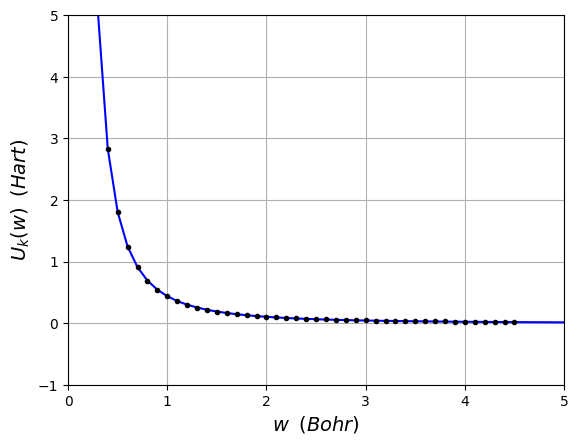

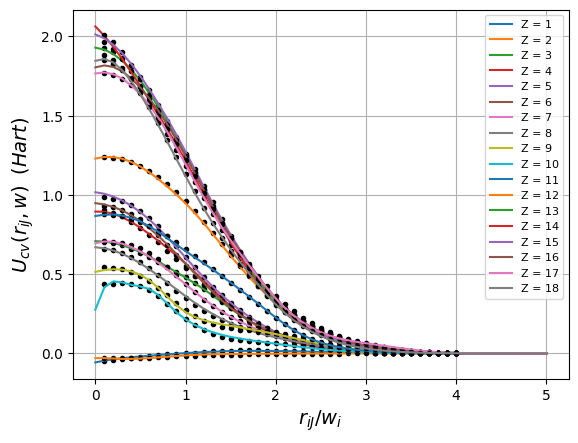

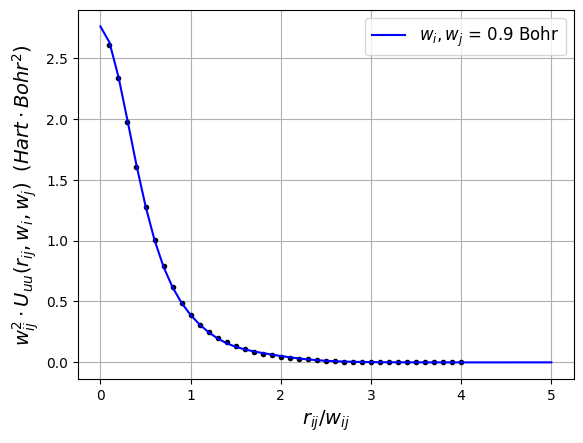

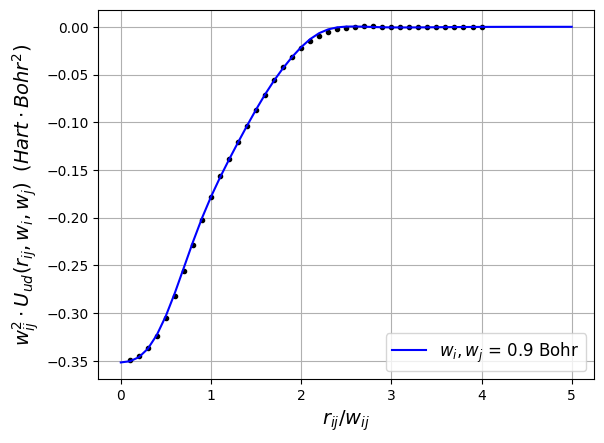

In [62]:
E0 = best_model[0]
ds = jnp.arange(0,5.1,0.1)

plt.plot(ds, [E0(jnp.array([0,d])) for d in ds], 'b')
plt.plot(w, Ek, 'k.')
plt.ylim(-1,5)
plt.xlim(0,5)
plt.grid()
plt.xlabel('$w \;\; (Bohr)$', fontsize=14)
plt.ylabel('$U_k(w) \;\; (Hart)$', fontsize=14)

plt.figure()
AE0 = best_model[1]

ind = 6

for i in range(18):
    def get_x(d, ind):
        x = jnp.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,d*w[ind],w[ind]])
        return x.at[i+5].set(1)
    plt.plot(rw, Ecv[i,:,ind], 'k.')
    plt.plot(ds, [AE0(get_x(d, ind)) for d in ds], label='Z = {}'.format(i+1))
plt.legend(fontsize=8)
plt.grid()
plt.xlabel('$r_{iJ}/w_i$', fontsize=14)
plt.ylabel('$U_{cv}(r_{iJ},w) \;\; (Hart)$', fontsize=14)

plt.figure()
EES0 = best_model[2]
plt.plot(rw, Euu[:,ind,ind]*2*w[ind]**2, 'k.')
plt.plot(ds, [2*w[ind]**2*EES0(jnp.array([0,0,0,0,0,d*jnp.sqrt(2)*w[ind], w[ind], w[ind]])) for d in ds], 'b', label='$w_i, w_j$ = {:.1f} Bohr'.format(w[ind]))
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xlabel('$r_{ij}/w_{ij}$', fontsize=14)
plt.ylabel('$w_{ij}^2 \cdot U_{uu}(r_{ij},w_i,w_j) \;\; (Hart \cdot Bohr^2)$', fontsize=14)

plt.figure()
EEO0 = best_model[3]
plt.plot(rw, Eud[:,ind,ind]*2*w[ind]**2, 'k.')
plt.plot(ds, [2*w[ind]**2*EEO0(jnp.array([0,0,0,0,0,d*jnp.sqrt(2)*w[ind], w[ind], w[ind]])) for d in ds], 'b', label='$w_i, w_j$ = {:.1f} Bohr'.format(w[ind]))
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.xlabel('$r_{ij}/w_{ij}$', fontsize=14)
plt.ylabel('$w_{ij}^2 \cdot U_{ud}(r_{ij},w_i,w_j) \;\; (Hart \cdot Bohr^2)$', fontsize=14)

plt.show()

In [37]:
eqx.tree_serialise_leaves("ae0.eqx", AE0)
eqx.tree_serialise_leaves("ees0.eqx", EES0)
eqx.tree_serialise_leaves("eeo0.eqx", EEO0)
eqx.tree_serialise_leaves("e0.eqx", E0)